<div align="center">

# Preprocessing Petawawa Research Forest Data

### Author: Harry Seely

</div>

![prf_image](https://opendata.nfis.org/mapserver/PRF_Layout.jpg)

This notebook provides python code to preprocess the Petawawa Research Forest (PRF) inventory and ancillary datasets.

All data is sourced from the following website: 

https://opendata.nfis.org/mapserver/PRF.html

Please consult this page to get the most up to date version of the PRF data.

## Table of Contents

1. Python environment setup

2. Load Packages

3. Download Data

4. Clean Data

5. Export Data

## Python Environment Setup <a class="anchor" id="env-setup"></a>

This tutorial is offered in Google Collab format primarily, but can also be run locally using jupyter notebooks.

**Environment setup is performed using the [uv package manager](https://docs.astral.sh/uv/) which will need to be installed to run the code.**

The uv package manager allows for the installation of specific package versions to maintain reproducibility. The list of packages and their versions is included in the `pyproject.toml` file. Read more about using PyTorch with uv in this [documentation](https://docs.astral.sh/uv/guides/integration/pytorch/).

**This code has been tested on Windows 11**

1. Open a terminal and check that uv is installed by running 

    ```
    uv
    ```

2. Ensure uv is up-to-date by running

    ```
    uv self update
    ```

3. Intialize the uv environment and install dependencies.

    ```
    uv sync
    ```

 ## Load Packages <a class="anchor" id="load-packages"></a>

In [1]:
import os
import pandas as pd
import geopandas as gpd
import requests, zipfile, io
import zipfile
import contextily as cx
import matplotlib.pyplot as plt
import rioxarray as rio
from rasterio.plot import show
import numpy as np
import laspy

## Define functions for later use

In [ ]:
def download_zip(url, outdir):

    r = requests.get(url)

    z = zipfile.ZipFile(io.BytesIO(r.content))

    z.extractall(outdir)

def plot_pc(pc, pt_size=60, plt_size=5, cmap='jet', margin_lim=0.05,bg_col="black"):
    """
    Function for plotting point cloud data.
    """

    fig = plt.figure(figsize=(plt_size, plt_size))
    plt.subplots_adjust(top=1 - margin_lim,
                    bottom=0 + margin_lim,
                    right=1 - margin_lim,
                    left=0 + margin_lim,
                    hspace=0,
                    wspace=0)
    
    ax = fig.add_subplot(projection='3d')

    ax.scatter(pc[:, 0],
               pc[:, 1],
               pc[:, 2],
               c=pc[:, 2],
               cmap=cmap,
               linewidth=1,
               alpha=1,
               s=pt_size)

    ax.set_axis_off()

    ax.set_facecolor(bg_col)

def write_las(xyz, out_fpath):

    header = laspy.LasHeader(point_format=3, version="1.4")
    header.offsets = np.min(xyz, axis=0)
    header.scales = np.array([0.1, 0.1, 0.1])

    las = laspy.LasData(header)

    las.x = xyz[:, 0]
    las.y = xyz[:, 1]
    las.z = xyz[:, 2]

    las.write(out_fpath)

## Download Data <a class="anchor" id="download-data"></a>

In [3]:
# Whether to download data (only needs to be done once, but some time...)

DOWNLOAD_DATA = False

url_dict = {

'prf_boundary': r"https://opendata.nfis.org/downloads/petawawa/Vector/Boundaries/prf_boundary.zip",

'plot_data_2014': r"https://opendata.nfis.org/downloads/petawawa/Vector/Forest%20Sample%20Plots/prf_forest_sample_plots_2014.zip",

'plot_data_2018': r"https://opendata.nfis.org/downloads/petawawa/Vector/Forest%20Sample%20Plots/SPL2018_EFI_ground_plots.zip",

# 'lidar_rasters': r"https://opendata.nfis.org/downloads/petawawa/Raster/LiDAR_2018/PRF_LiDAR2018_Predictors.zip",

# 'dtm': r"https://opendata.nfis.org/downloads/petawawa/Raster/LiDAR_2018/prf_spl2018_dtm_50cm_wgs84.zip",

# 'lidar': r"https://opendata.nfis.org/downloads/petawawa/Raster/LiDAR_2018/PRF_LiDAR2018_LAS.zip"

}

url_dict

{'prf_boundary': 'https://opendata.nfis.org/downloads/petawawa/Vector/Boundaries/prf_boundary.zip',
 'plot_data_2014': 'https://opendata.nfis.org/downloads/petawawa/Vector/Forest%20Sample%20Plots/prf_forest_sample_plots_2014.zip',
 'plot_data_2018': 'https://opendata.nfis.org/downloads/petawawa/Vector/Forest%20Sample%20Plots/SPL2018_EFI_ground_plots.zip'}

In [4]:
data_dir = 'data'

# Create a directory to store the data
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [5]:
if DOWNLOAD_DATA:
    
    for key, url in url_dict.items():   

            print(f"Downloading {key}...")

            download_zip(url, data_dir)

# Check files in data directory
downloaded_ls = os.listdir(data_dir)
print(downloaded_ls)


['AFRIT_PRF_Lidar_Inventory_Field_Protocols_June 9_2014.pdf', 'Final AFRIT-PRF Plot Summary for Don.xlsx', 'forest_sample_plots_thumbnails.png', 'lidar', 'Points', 'Polygons', 'prf_boundary', 'prf_spl2018_dtm_50cm_wgs84.tif', 'SPL2018_EFI_ground_plots', 'SPL2018_EFI_predictors']


## Clean Vector Data <a class="anchor" id="clean-data"></a>

In [6]:
# PRF Boundary
boundary_gdf = gpd.read_file(os.path.join(data_dir, 'prf_boundary/prf_boundary.shp'))

<Axes: >

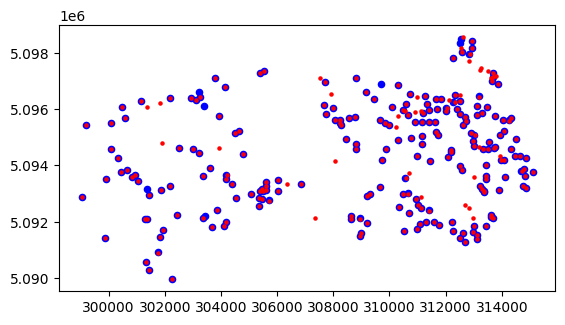

In [7]:
# Read plot data

plots_2018_fpath = r'data/SPL2018_EFI_ground_plots/PRF_SPL2018_EFI_plots_pts_wgs84.shp'
plots_2018_gdf = gpd.read_file(plots_2018_fpath)

plots_2014_fpath = r'data\Points\AFRITPRF_Points_Sept26_14.shp'
plots_2014_gdf = gpd.read_file(plots_2014_fpath)


plots_2014_gdf.to_crs(plots_2018_gdf.crs, inplace=True)

# Visualize both plot data sets
ax = plots_2014_gdf.plot(color='blue',  markersize=20)
plots_2018_gdf.plot(ax=ax, color='red', markersize=5)

In [8]:
# Load and explore tree data

trees_fpath = r"data/SPL2018_EFI_ground_plots/PRF_CNL_SPL_CalibrationData_LiveDeadStems.xlsx"

trees_df = pd.read_excel(trees_fpath, sheet_name="Tree")

trees_df

,tree_spec,PlotName,TreeID,TreeSpec,Origin,Status,DBH,CrownClass,QualityClass,DecayClass,...,BA_all,TPH_all,codom,domht,ht_meas,stems,mvol,tvol,biomass,size
0,1,PRF001,24.0,1,P,D,10.1,NaN,NaN,1.0,...,33.601655,2688,N,12.223077,NaN,16,0.000000,0.708735,393.396400,Poles
1,1,PRF001,46.0,1,P,D,9.9,NaN,NaN,2.0,...,33.601655,2688,N,12.223077,NaN,16,0.000000,0.673254,375.305379,Poles
2,2,PRF001,20.0,2,N,L,67.5,D,A,NaN,...,33.601655,2688,Y,33.433333,33.9,16,77.327438,79.482658,39691.639950,Large
3,2,PRF001,50.0,2,N,L,57.9,D,U,NaN,...,33.601655,2688,Y,33.433333,NaN,16,56.444281,58.117292,28251.255888,Large
4,1,PRF001,10.0,1,N,L,55.9,D,A,NaN,...,33.601655,2688,Y,33.433333,33.0,16,48.008649,49.833743,24501.838779,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,30,PRF334,NaN,30,N,L,3.7,NaN,NaN,NaN,...,27.644145,2712,N,13.266667,NaN,200,0.000000,0.858564,851.191939,Under
12586,30,PRF334,NaN,30,N,L,3.3,NaN,NaN,NaN,...,27.644145,2712,N,13.266667,8.5,200,0.000000,0.653868,659.084439,Under
12587,30,PRF334,NaN,30,N,L,3.2,NaN,NaN,NaN,...,27.644145,2712,N,13.266667,NaN,200,0.000000,0.607493,615.333049,Under
12588,30,PRF334,NaN,30,N,L,3.0,NaN,NaN,NaN,...,27.644145,2712,N,13.266667,7.4,200,0.000000,0.469656,521.064025,Under


## Make a map of PRF Plots

Text(0.5, 1.0, 'PRF Ground Plots')

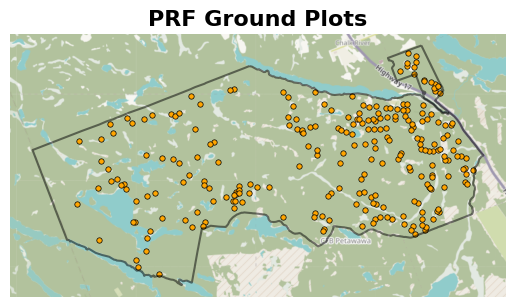

In [9]:
# Convert to web mercator for plotting
plots_2018_gdf_wm = plots_2018_gdf.to_crs(epsg=3857)

ax = plots_2018_gdf_wm.plot(facecolor="orange", 
                       edgecolor='black',
                       markersize=15,
                       linewidth=0.5)

boundary_gdf.to_crs(epsg=3857).plot(ax=ax, 
                                    color='none', 
                                    edgecolor='black', 
                                    linewidth=1.5,
                                    alpha=0.5)

cx.add_basemap(ax, attribution='')

# Remove axis labels and ticks
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

# Add title
ax.set_title("PRF Ground Plots", fontsize=16, fontweight='bold', loc='center')

# Save plot to file
# plt.savefig(r"images/prf_ground_plots_map.png", dpi=300, bbox_inches='tight')



## Check 99th height percentile raster

In [10]:
p99_fpath = r"data/SPL2018_EFI_predictors/PRF_AR_FPC_p99_T0_M_wgs84.tif"

p99 = rio.open_rasterio(p99_fpath)

print(f"P99 Raster has resolution of {p99.rio.resolution()[0]} m")

p99

P99 Raster has resolution of 25.0 m


<xarray.DataArray (band: 1, y: 366, x: 746)> Size: 1MB
[273036 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_MAXIMUM:      45.569999694824
    STATISTICS_MEAN:         25.239122333602
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       5.3449476495645
    _FillValue:              -3.4028235e+38
    scale_factor:            1.0
    add_offset:              0.0

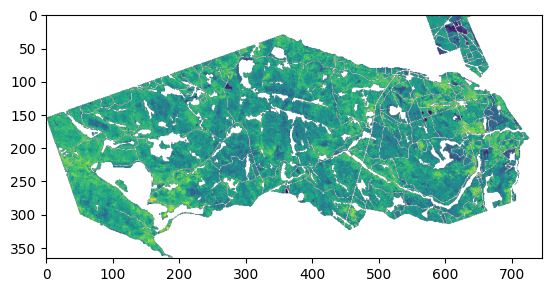

<Axes: >

In [11]:
# Set nodata values to np.nan
p99.values = np.where(p99.values == p99.rio.nodata, np.nan, p99.values)

show(p99.values, cmap='viridis')

## Create subset of LiDAR data

In [12]:
lidar_index = gpd.read_file(r'data/lidar/OMNRF_Petawawa_sheets_updated.shp')

1kmZ183060509402018L


<Axes: >

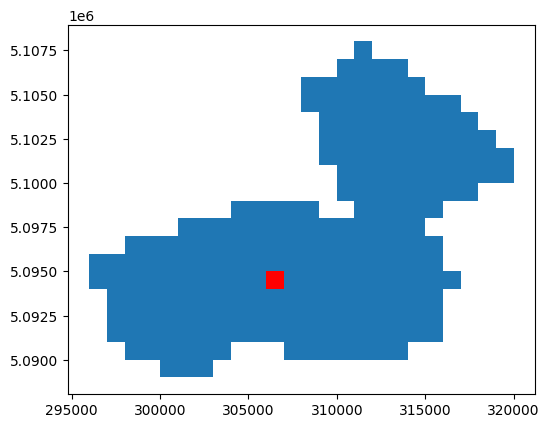

In [13]:
target_refname = lidar_index['RefName_1'][74]

print(target_refname)

sub_gdf = lidar_index[lidar_index['RefName_1'] == target_refname].copy()

ax = lidar_index.plot()

sub_gdf.plot(ax=ax, color='red')


In [14]:
# Read the laz file
pc_fpath = r'data/lidar/1kmZ183060509402018L.laz'

las = laspy.read(pc_fpath)

crs = las.header.parse_crs()

print(f"LAS CRS: {crs}")

print(f"LAS Header: {las.header}")

points = np.vstack([las.x, las.y, las.z]).transpose()


LAS CRS: COMPD_CS["NAD83(CSRS) / UTM zone 18N + CGVD2013 height - CGG2013 - NAD83(CSRS)",PROJCS["NAD83(CSRS) / UTM zone 18N",GEOGCS["NAD83(CSRS)",DATUM["NAD83_Canadian_Spatial_Reference_System",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6140"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4617"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2959"]],VERT_CS["CGVD2013 height - CGG2013 - NAD83(CSRS)",VERT_DATUM["Canadian Geodetic Vertical Datum of 2013",2005,AUTHORITY["EPSG","1127"]],HEIGHT_MODEL["CGG2013 NAD83"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6647"]]]
LAS Header: <L

<Axes: >

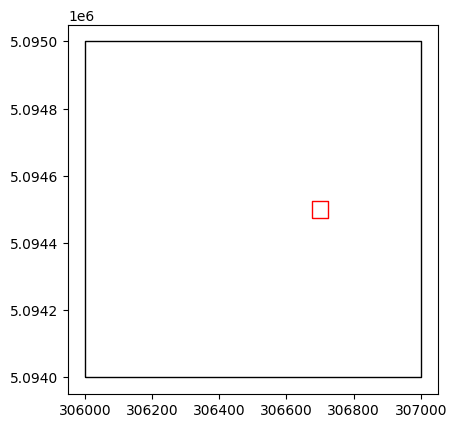

In [15]:
# Apply a negative buffer to the sub area
buffer = -475
sub_gdf_red = sub_gdf.copy()
sub_gdf_red.geometry = sub_gdf.buffer(buffer)

# Translate bbox 100m to the right
sub_gdf_red.geometry = sub_gdf_red.translate(xoff=200, yoff=0)

ax = sub_gdf.plot(facecolor='none', edgecolor='black', linewidth=1)
sub_gdf_red.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)


In [16]:
# Clip points to negative buffer

# Get buffer bounds
bounds = sub_gdf_red.bounds

# Get points within bounds
mask = ((points[:, 0] >= bounds['minx'].values[0]) & \
       (points[:, 0] <= bounds['maxx'].values[0]) & \
       (points[:, 1] >= bounds['miny'].values[0]) & \
       (points[:, 1] <= bounds['maxy'].values[0]))

# Get clipped points
clipped_points = points[mask]
print(clipped_points.shape)

(79223, 3)


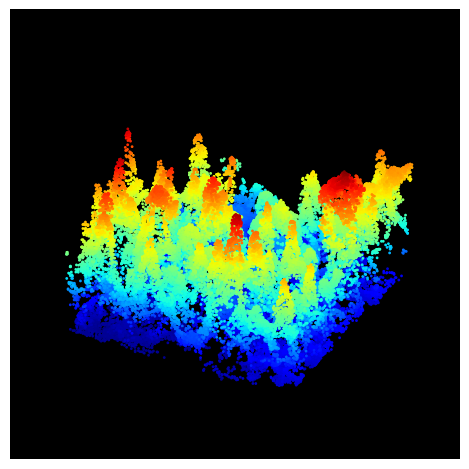

In [17]:
plot_pc(clipped_points, pt_size = 1)

 ## Export and Compress Data <a class="anchor" id="export"></a>

In [18]:

out_dict = {
    'boundary': 'boundary.gpkg',
    'trees': 'trees.csv',
    'plots': 'plots.gpkg',
    'p99': 'p99.tif',
    'lidar': "forest_point_cloud.las"
}

# Export vector data
boundary_gdf.to_file(out_dict['boundary'], driver='GPKG', index=False)
trees_df.to_csv(out_dict['trees'], index=False)
plots_2018_gdf.to_file(out_dict['plots'], driver='GPKG', index=False)

# Export raster data
p99.rio.to_raster(out_dict['p99'], driver='GTiff')

# Export lidar data
write_las(clipped_points, out_dict['lidar'])


In [19]:
# Zip data so it can be uploaded to google drive

zip_file_name = 'prf_data.zip'

files_to_compress = out_dict.values()

zip_object = zipfile.ZipFile(zip_file_name, 'w')

print(f"Zipping following files into {zip_file_name}:\n\n{"\n".join(files_to_compress)}")

for file_name in files_to_compress:
    zip_object.write(file_name, compress_type=zipfile.ZIP_DEFLATED)

zip_object.close()

print(f"Data zipped to {zip_file_name}")

Zipping following files into prf_data.zip:

boundary.gpkg
trees.csv
plots.gpkg
p99.tif
forest_point_cloud.las
Data zipped to prf_data.zip


In [20]:
# Remove unzipped files
for file_name in files_to_compress:
    os.remove(file_name)